# "বাংলাদেশে করোনা ভাইরাস সংক্রমণের পরিসংখ্যান"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/bangladesh-rt.png
- hide: false
- search_exclude: true
- metadata_key1: bangladesh
- metadata_key2: covid-19

In [2]:
#hide_input
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d
import logging

from IPython.display import clear_output
import matplotlib.font_manager as fm

prop = fm.FontProperties(fname='kalpurush.ttf')

%config InlineBackend.figure_format = 'retina'

## দৈনিক করোনা আক্রান্তের সংখ্যা
[ডেটা](https://github.com/datasets/covid-19)  

In [3]:
#hide_input
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import altair as alt

# https://github.com/datasets/covid-19
ts = pd.read_csv('covid-19/data/countries-aggregated.csv',
                parse_dates=['Date'],
                usecols = ['Date', 'Country', 'Confirmed'],
                index_col=['Country', 'Date'],
                squeeze=True).sort_index()
#ts['Bangladesh'].head(50).tail()

In [4]:
#hide_input
def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

country_name = 'Bangladesh'
bts = ts.xs(country_name).rename(f"{country_name} cases")

original, smoothed = prepare_cases(bts)

# Visualize
df_actual = pd.DataFrame({'Date': original.index.values, 'confirmed_cases': original, 'Type': 'actual'})
df_smoothed = pd.DataFrame({'Date': smoothed.index.values, 'confirmed_cases': smoothed, 'Type': 'smoothed'})
df = pd.concat([df_actual, df_smoothed])
df.head()

color_var=alt.Color('Type:N', scale=alt.Scale(scheme='tableau20'), legend=None)
chart = alt.Chart(df).mark_line().encode(
    x=alt.X('monthdate(Date):O', axis=alt.Axis(title='Date')),
    y=alt.Y('confirmed_cases', axis=alt.Axis(title='Confirmed cases')),
    color=color_var,
    tooltip=['monthdate(Date):O', 'confirmed_cases'],
    
).properties(
    title=f"{country_name} New Cases per Day"
)

legend = alt.Chart(df).mark_point().encode(
    y=alt.Y('Type', axis=alt.Axis(orient='right')),
    color=color_var
)
chart.properties(width=600, height=300)|legend

alt.HConcatChart(...)

## R সংখ্যা

R সংখ্যাটি কোনও রোগের ছড়িয়ে যাওয়ার ক্ষমতাকে রেটিং দেওয়ার উপায়। একজন সংক্রামিত ব্যক্তি থেকে গড়ে এই ভাইরাসটি কতো লোকে সংক্রামিত হবে এই সংখ্যা সেটা বলে। সময়ের সাথে সাথে পরিবর্তিত হয় বলে এটাকে Rt ও বলা হয়। নতুন করোনাভাইরাস, কোভিড-১৯, এর R সংখ্যা প্রায় ৩। মিসেল্স বা হাম এর R প্রায় ১৫ যেটা সর্বাধিক। [সূত্রঃ বিবিসি](https://www.bbc.com/news/health-52473523)

[কোল্যাব নোটবুক](https://colab.research.google.com/github/sohojai/covid19/blob/master/_notebooks/Bangladesh_Covid19_Rt.ipynb)  
[মূল কোড](https://github.com/k-sys/covid-19) 


In [5]:
#hide_input

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

In [6]:
#hide_input
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    # Map Rt into lambda so we can substitute it into the equation below
    # Note that we have N-1 lambdas because on the first day of an outbreak
    # you do not know what to expect.
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

In [7]:
#hide_input
# MLE to find sigma
sigmas = np.linspace(1/20, 1, 20)

new, smoothed = prepare_cases(bts, cutoff=25)
if len(smoothed) == 0:
    new, smoothed = prepare_cases(bts, cutoff=10)

result = {}

# Holds all posteriors with every given value of sigma
result['posteriors'] = []

# Holds the log likelihood across all k for each value of sigma
result['log_likelihoods'] = []

for sigma in sigmas:
    posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
    result['posteriors'].append(posteriors)
    result['log_likelihoods'].append(log_likelihood)

clear_output(wait=True)
sigma = sigmas[np.argmax(result['log_likelihoods'])]
posteriors = result['posteriors'][np.argmax(result['log_likelihoods'])]
logging.debug(f"Sigma: {sigma} has highest log likelihood")
logging.debug('Done.')
      
# Plot it
#fig, ax = plt.subplots()
#ax.set_title(f"Maximum Likelihood value for $\sigma$");
#ax.plot(sigmas, result['log_likelihoods'])
#ax.axvline(sigma, color='k', linestyle=":")

In [8]:
#hide_input
# Calculate High density interval
def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])



# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

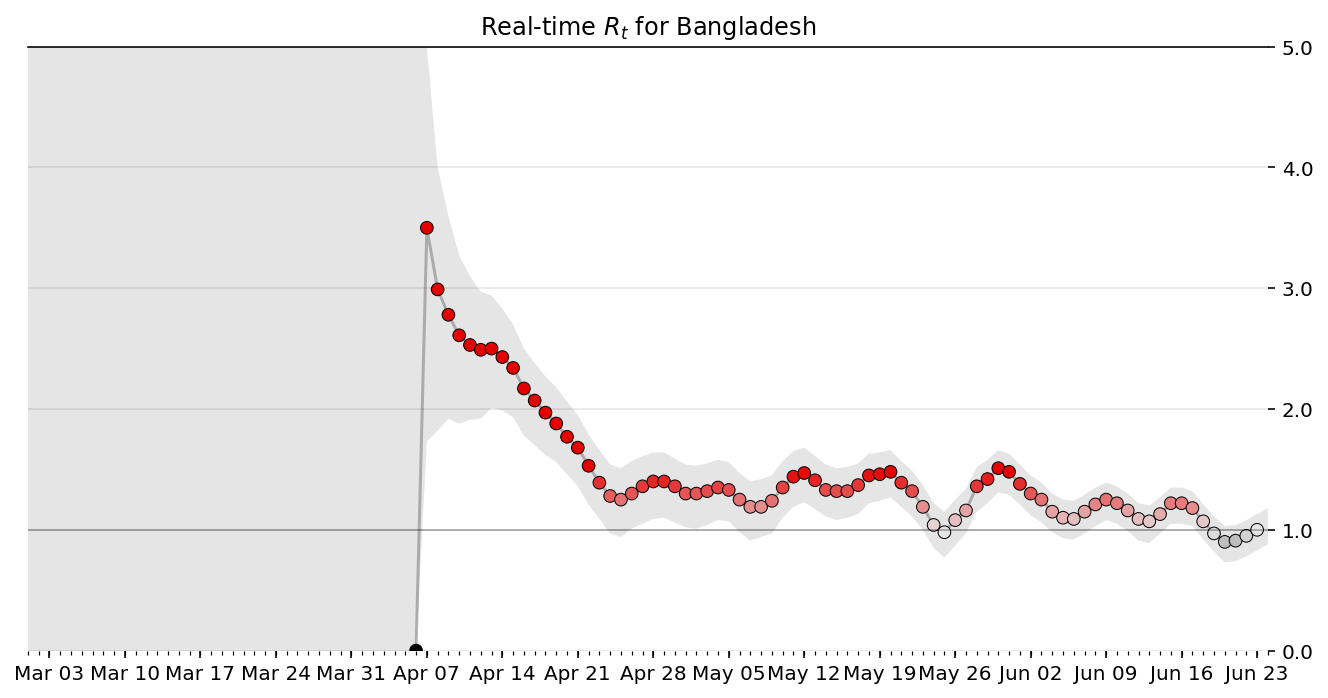

In [12]:
#hide_input
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('Date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')
    fig.savefig('../images/bangladesh-rt.png')  

    
fig, ax = plt.subplots(figsize=(800/72,400/72))

plot_rt(result, ax, country_name)
ax.set_title(f'Real-time $R_t$ for {country_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))